# Object detection with OWLv2

OWL model is a minimal modification of OpenAI's model to do zero-shot object detection.

Ref. Paper: [OWL v2](https://arxiv.org/pdf/2306.09683.pdf), [OWL ViT](https://arxiv.org/pdf/2205.06230.pdf), [ViT](https://arxiv.org/pdf/2010.11929.pdf), [CLIP](https://arxiv.org/pdf/2103.00020.pdf)

Ref. github: [transformers](https://github.com/huggingface/transformers/blob/main/src/transformers/models/owlv2), [google-research](https://github.com/google-research/scenic/tree/main/scenic/projects/owl_vit)

Ref. Notebooks: [NielsRogge](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/OWLv2/Zero_and_one_shot_object_detection_with_OWLv2.ipynb), [google-research](https://github.com/google-research/scenic/blob/main/scenic/projects/owl_vit/notebooks/OWL_ViT_minimal_example.ipynb)

# Download Dependencies

In [3]:
# !../scripts/setup-env.sh
# !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -e ../libs

# Download Datasets
Amazon bin images (aws bucket - 'aft-vbi-pds', filtered by [IK index file](../libs/binsense/resources/ik_data_index.csv))\
Annotated Amazon bin images from roboflow (nitesh-c-eszzc/binsense_segments)

In [4]:
from binsense.dataprep import metadata, downloader
from binsense import config as cfg
from binsense.roboflow_wrapper import RoboProj

import roboflow

# download Amazon bin images & meta-data
downloader.download()

# download Roboflow project
# creates a config file (~/.config/roboflow/config.json) after you login first time
roboflow.login()
rf = roboflow.Roboflow()
proj_binsense =  RoboProj(
    rf, 
    rf_proj=rf.project(f'{cfg.BIN_ROBO_WORKSPACE}/{cfg.BIN_ROBO_PROJECT}'),
    proj_ver=1
)
ds_binsense = proj_binsense.download(
    dataset_path=cfg.BIN_ROBO_DOWNLOAD_DIR,
    dataset_format='coco')
print("Downloaded dataset paths")
for i in range(0, len(ds_binsense.get_all_images_dir())):
    print(ds_binsense.get_all_images_dir()[i], ds_binsense.get_all_labels_dir()[i])


bin_df, item_df = metadata.load()
item_df.sort_values(by="item_id", inplace=True)
item_df.head()

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).



Extracting Dataset Version Zip to /Users/n0c09jf/code/github/binsense/_data/robo in coco:: 100%|██████████| 45/45 [00:00<00:00, 47.24it/s]


Downloaded dataset paths
/Users/n0c09jf/code/github/binsense/_data/robo/valid /Users/n0c09jf/code/github/binsense/_data/robo/valid/_annotations.coco.json
/Users/n0c09jf/code/github/binsense/_data/robo/test /Users/n0c09jf/code/github/binsense/_data/robo/test/_annotations.coco.json
/Users/n0c09jf/code/github/binsense/_data/robo/train /Users/n0c09jf/code/github/binsense/_data/robo/train/_annotations.coco.json


,bin_id,item_id,item_name,item_qty,item_length,item_length_unit,item_width,item_width_unit,item_height,item_height_unit,item_weight,item_weight_unit
1696,00638,0002624028,THE KREMLIN'S DILEMMA: The Struggle for Human ...,1,8.267717,IN,5.669291,IN,1.496063,IN,1.190000,pounds
9423,10180,0061986623,Another Summer: A Beach House Novel,1,7.900000,IN,5.200000,IN,1.100000,IN,0.950000,pounds
9502,07215,0062080644,Super Immunity: The Essential Nutrition Guide ...,3,7.795276,IN,5.196850,IN,0.866142,IN,0.485012,pounds
5696,07214,0062080644,Super Immunity: The Essential Nutrition Guide ...,3,7.795276,IN,5.196850,IN,0.866142,IN,0.485012,pounds
9424,10180,0062111736,Folly Beach: A Lowcountry Tale,1,7.900000,IN,5.300000,IN,1.200000,IN,0.550000,pounds


## Load model and processor

OWLv2 checkpoint from the [hub](https://huggingface.co/models?other=owlv2). Based on the reference notebook, ensemble checkpoint performs best. Larger checkpoints are available.

In [5]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection
import numpy as np
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD
from PIL import Image
from matplotlib import pyplot as plt
import cv2 as cv


processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

# this is to get the pre-processed image for visualization
#   resized and padded before normalizing
def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

# draws the bounding boxes on the cv image
# and plots it in the grid with each image+bbox per grid
def show_bbox_ingrid(cv_img, box_scores, grid, title=None):
    rows, cols = grid
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    for i in range(0, rows):
        for j in range(0, cols):
            bi = i*cols+j
            if bi >= len(box_scores):
                continue
            
            draw_img = cv_img.copy()
            box = [int(k) for k in box_scores[bi][0].tolist()]
            draw_img = cv.rectangle(draw_img, box[:2], box[2:], (0,0,255), 5)
            axs[i][j].imshow(draw_img, cmap = plt.cm.Spectral)
            axs[i][j].text(0, 0,
                f'Score: {box_scores[bi][1]:1.3f}',
                ha='left',
                va='top',
                color='black',
                bbox={
                    'facecolor': 'white',
                    'alpha': 0,
                    # 'edgecolor': 'lime',
                    'boxstyle': 'square,pad=.1',
                })
    if title:
        fig.suptitle(title)
    plt.show()

## Sample images for OwlV2 model
Sample few set of 3 bin images with same items. We will pick one or two sets and then annotate them in roboflow and run the model inference.

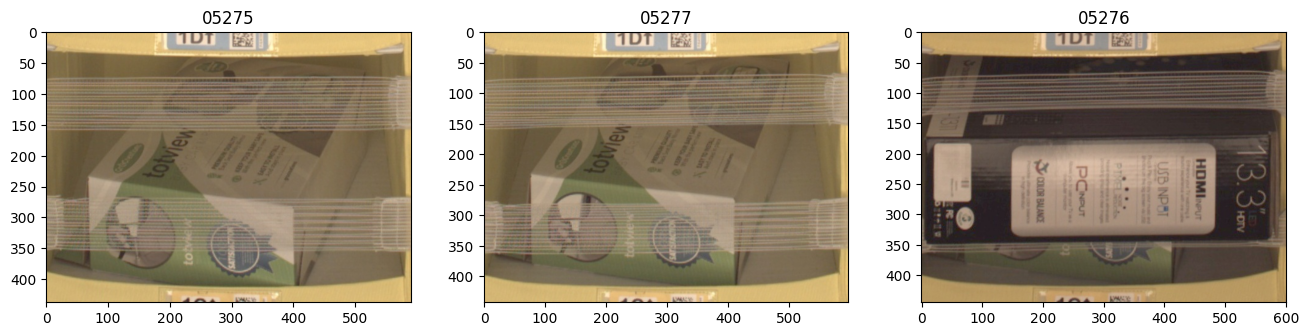

In [6]:
from binsense import config as cfg
from matplotlib import pyplot as plt
from PIL import Image

import os

# lets take a random item which exists in more than one bin to do the analysis
def to_bin_image(bin_id):
    return Image.open(os.path.join(cfg.BIN_S3_DOWNLOAD_IMAGES_DIR, f'{bin_id}.jpg'))

def show_sample(sampled_bins):
    cols = len(sampled_bins)
    fig, axs = plt.subplots(1, cols, figsize=(16,4))
    for i, bin_id in enumerate(sampled_bins):
        # show images row
        img = to_bin_image(bin_id)
        axs[i].imshow(img, cmap = plt.cm.Spectral)
        axs[i].set_title(bin_id)
    plt.show()
    
def run_sample():
    df = item_df.groupby(['item_id'])['bin_id'].nunique().reset_index(name="bins")
    sampled_item_ids = df[df['bins'] > 2].sample(1)['item_id']
    sampled_bins = item_df[item_df.item_id.isin(sampled_item_ids)]['bin_id'].unique()

    show_sample(sampled_bins)

run_sample()

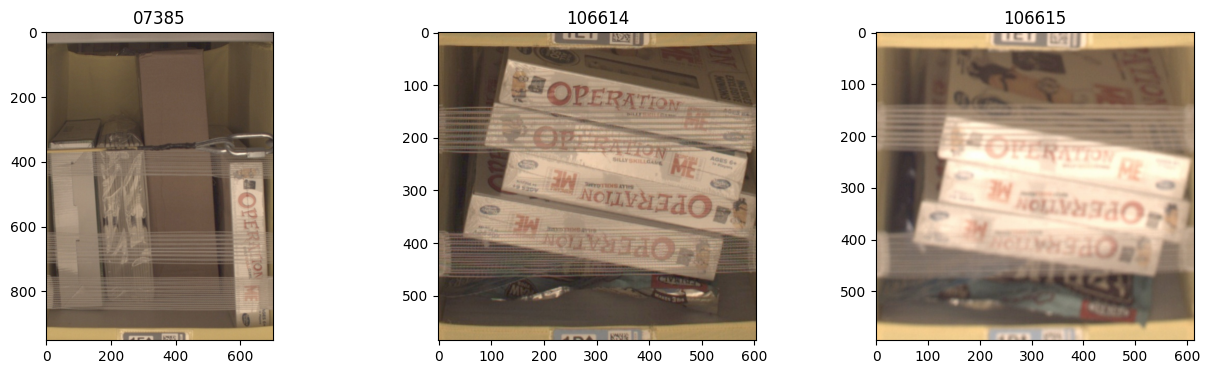

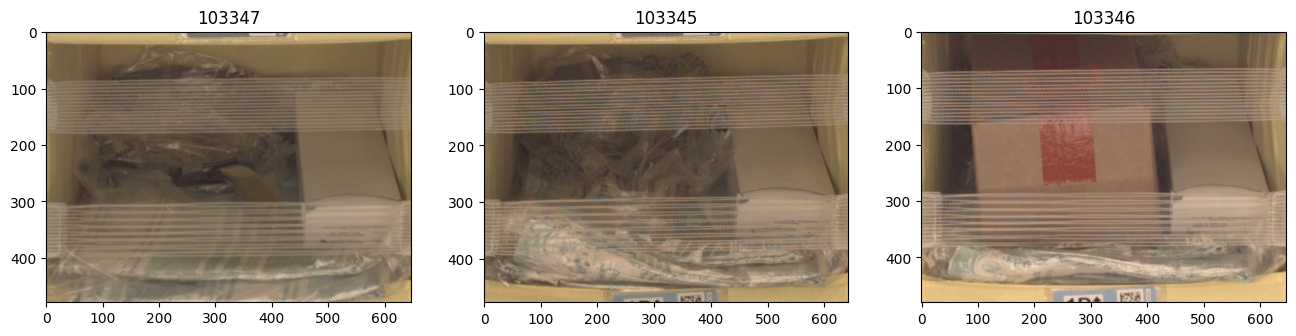

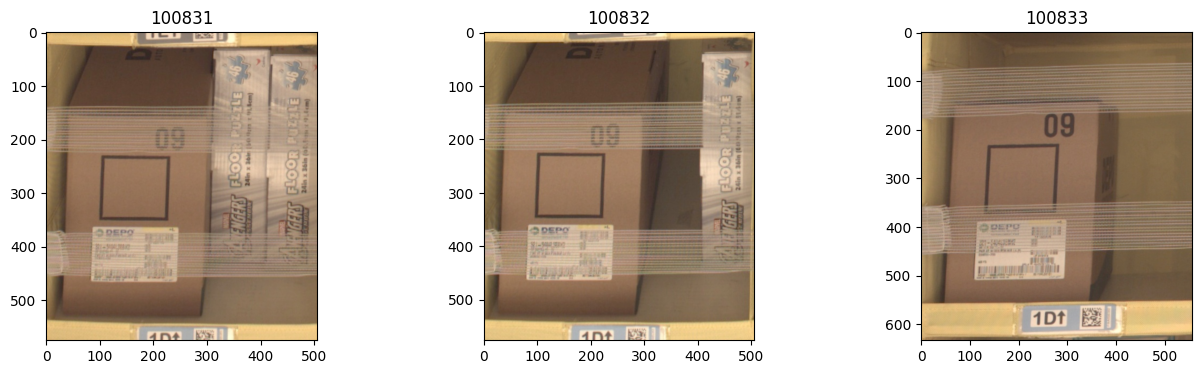

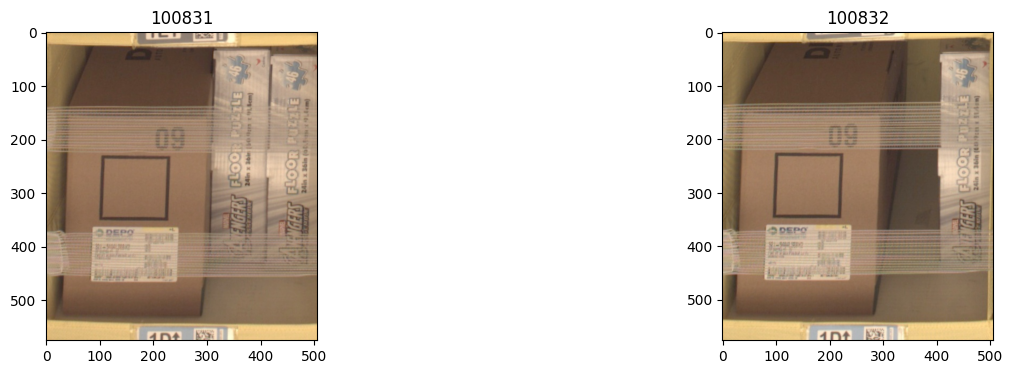

In [7]:
# ran the samples multiple items to arrive these sets which we will explore.
frozen_bin_ids = [
    ['07385', '106614', '106615'],
    ['103347', '103345', '103346'], 
    ['100831', '100832', '100833'],
    ['100831', '100832']
]
for sample in frozen_bin_ids:
    show_sample(sample)

## Prepare image and queries for the model

We will be doing the image based queries based on the samples. Prepare the images for the queries.\
Query Bin: 100832 (extract the query item from this bin using roboflow) \
Target Bin: 100831

In [8]:
QUERY_BIN = '100832'
QUERY_ITEM_ID = 'B00GZPF4FA'
TARGET_BINS = ['100831']

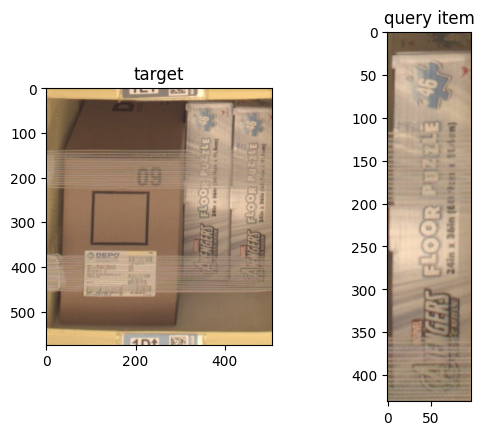

In [9]:
from binsense.dataset_util import COCODatasetBuilder
from binsense.utils import ImageFileIterator
from PIL import Image

# Load the Query & Target bin image
query_bin_image = to_bin_image(QUERY_BIN)
target_bin_image = to_bin_image(TARGET_BINS[0])

# Load the Query Item image from Roboflow
query_item_image = None
binsense_dir = ds_binsense.get_images_dir('train')
coco_ds = COCODatasetBuilder.build_from_file(ds_binsense.get_labels_dir('train'))
for img_path in ImageFileIterator(binsense_dir):
    bin_fname = img_path.split('/')[-1]
    bin_id = bin_fname.split('_jpg')[0]
    if bin_id == QUERY_BIN:
        # returns a list of Dict[label, bbox]
        query_bboxes = coco_ds.get_bbox(bin_fname)
        query_bbox = list(filter(lambda x: x[0] == QUERY_ITEM_ID, query_bboxes))[0][1]
        (x1, y1, x2, y2) = (query_bbox[0], query_bbox[1], query_bbox[0]+query_bbox[2], query_bbox[1]+query_bbox[3])
        query_item_image = query_bin_image.crop((x1, y1, x2, y2))
        break;

if query_item_image is None:
    raise ValueError("Query Bin not found in the roboflow dataset. \
        check the tag (valid/test/train) to see if the bin images \
            are annotated and exist in the roboflow downloaded datasets.")

#display target and query side-vis-side
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(target_bin_image)
ax1.set_title('target')
ax2.imshow(query_item_image)
ax2.set_title('query item')
plt.show()

## Extract the embedding of the item in the Query Item Image

torch.Size([1, 60, 60, 768])
torch.Size([1, 3600])
Index: 1563
Objectness: 0.23197319
box: [0.11616949 0.5043856  0.22370695 0.9867323 ]
Index: 1627
Objectness: 0.090469256
box: [0.13381557 0.45386544 0.10706878 0.43044674]
Index: 3006
Objectness: 0.0926035
box: [0.13332991 0.8343196  0.12621644 0.29217178]


Text(0.5, 1.0, 'Top 3 objects by objectness')

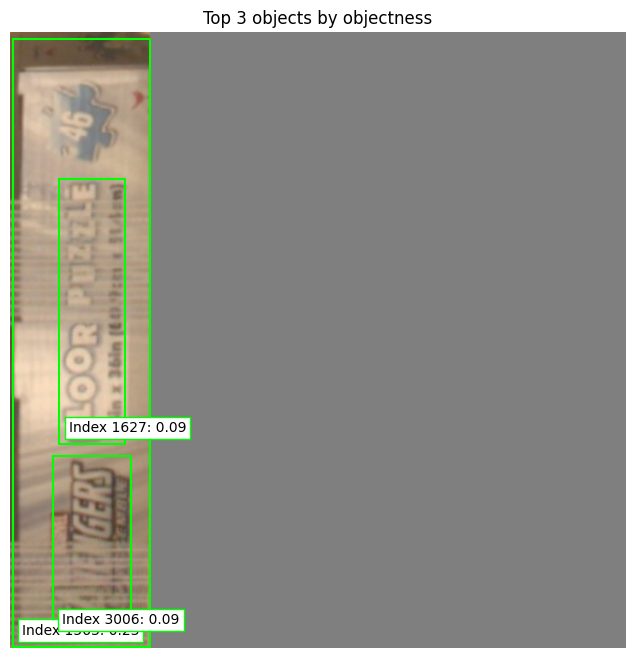

In [10]:
import torch
from scipy.special import expit as sigmoid

# preprocess the image for the model input
query_item_pixel_values = processor(images=query_item_image, return_tensors="pt").pixel_values
with torch.no_grad():
    output = model.image_embedder(query_item_pixel_values)
    query_item_embedding = output[0]
print(query_item_embedding.shape)

# Rearrange feature map
batch_size, height, width, hidden_size = query_item_embedding.shape
query_item_image_features = query_item_embedding.reshape(batch_size, height * width, hidden_size)

# Get the top 3 objects on the image
query_item_objectnesses = model.objectness_predictor(query_item_image_features)
query_item_bboxes = model.box_predictor(query_item_image_features, feature_map=query_item_embedding)
query_item_object_embeddings = model.class_predictor(query_item_image_features)[1]
print(query_item_objectnesses.shape)

# Remove batch dimension
objectnesses = np.array(query_item_objectnesses[0].detach())
boxes = np.array(query_item_bboxes[0].detach())
object_embeddings = np.array(query_item_object_embeddings[0].detach())

# Plot top 3 objects on Query Item Image
top_k = 3
objectnesses = sigmoid(objectnesses)
objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]
padded_query_item_image = get_preprocessed_image(query_item_pixel_values)
target_sizes = torch.Tensor([padded_query_item_image.size[::-1]])
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(padded_query_item_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for i, (box, objectness) in enumerate(zip(boxes, objectnesses)):
  if objectness < objectness_threshold:
    continue

  cx, cy, w, h = box
  ax.plot(
      [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
      [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
      color='lime',
  )

  print("Index:", i)
  print("Objectness:", objectness)
  print("box:", box)

  ax.text(
      cx - w / 2 + 0.015,
      cy + h / 2 - 0.015,
      f'Index {i}: {objectness:1.2f}',
      ha='left',
      va='bottom',
      color='black',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'lime',
          'boxstyle': 'square,pad=.3',
      },
  )

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top {top_k} objects by objectness')

torch.Size([1, 1, 512]) torch.Size([1, 3600, 768])
Number of boxes filtered,  2


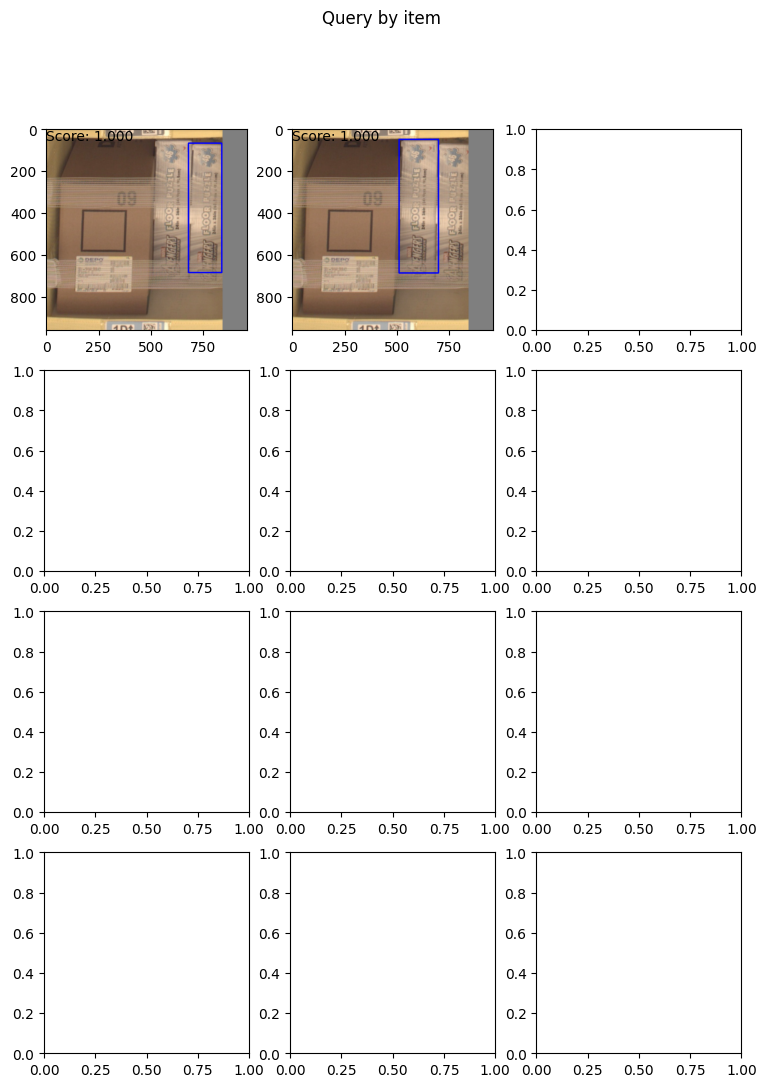

In [11]:
from transformers.models.owlv2.modeling_owlv2 import Owlv2ImageGuidedObjectDetectionOutput

query_object_index = 1563  # Index of the item box above.
query_embedding = np.array(query_item_object_embeddings[0].detach())[query_object_index]

# get the target image embedding
target_bin_image = to_bin_image(TARGET_BINS[0])
target_pixel_values = processor(
    images=target_bin_image, 
    return_tensors='pt').pixel_values
with torch.no_grad():
    output = model.image_embedder(target_pixel_values)
    target_embedding = output[0]
    batch_size, num_patches, num_patches, hidden_dim = target_embedding.shape
    target_feats = torch.reshape(
        target_embedding, (batch_size, num_patches * num_patches, hidden_dim))

# query the target image embedding with query embedding extracted
query_embedding = torch.reshape(torch.Tensor(query_embedding), (1, 1, 512))
print(query_embedding.shape, target_feats.shape)
(pred_logits, class_embeds) = model.class_predictor(
    image_feats=target_feats, query_embeds=query_embedding)
target_pred_boxes = model.box_predictor(
    image_feats=target_feats, feature_map=target_embedding)

# package the output for the postprocessor
modelOutput = Owlv2ImageGuidedObjectDetectionOutput(
    logits=pred_logits, target_pred_boxes=target_pred_boxes)

# get padded target image to plot the bboxes
padded_target_image = get_preprocessed_image(target_pixel_values)
target_sizes = torch.Tensor([padded_target_image.size[::-1]])

# filter the bboxes with the threshold
#   & also resize the bboxes against the padded target image size in pixels.
# good threshold values: 0.98, 0.95
results = processor.post_process_image_guided_detection(
    outputs=modelOutput, threshold=0.998, 
    nms_threshold=1, target_sizes=target_sizes)

# Plot the bboxes on the grid with one bbox per grid cell.
boxes, scores = results[0]["boxes"], results[0]["scores"]
box_scores = [(boxes[i], scores[i]) for i in range(0, len(boxes))]
box_scores = sorted(box_scores, key=lambda box_score: box_score[1], reverse=True)
print("Number of boxes filtered, ", len(box_scores))

show_bbox_ingrid(
    np.array(padded_target_image), 
    box_scores, 
    (4, 3), 
    "Query by item")